# Codes to reproduce all results of "Libration and precession driven dissipation in the fluid cores of the TRAPPIST-1 planets" (Planetary Science Journal)

## Codes written by Dhananjhay Bansal, Hannah Christies and Mathieu Dumberry

In [213]:
#pip install import_ipynb

In [11]:
import pandas as pd
import numpy as np
from math import pi
from numpy import cos,sin
from numpy.linalg import eig
from scipy.integrate import odeint,quad
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from random import seed
import import_ipynb
#import Eigen_Trappist1_initial_Conditions
#from Eigen_Trappist1_initial_Conditions import T,eigvals_B,gamma,eigvecs_B,e_time,e_time10

In [12]:
pd.options.display.float_format = '{:.3f}'.format

## Table with data of Trappist-1 planets

In [13]:
data = {
    'Planet Name': ['TRAPPIST-1 b','TRAPPIST-1 c','TRAPPIST-1 d',
                    'TRAPPIST-1 e','TRAPPIST-1 f','TRAPPIST-1 g'
                    ,'TRAPPIST-1 h'] , 
     'Period(day)':  [1.510826,2.421937,4.049219,6.101013,9.207540,
                     12.352446,18.772866],
 # Non-hydrostatic case
 #    'Period(day)':  [1.510826,2.421937,4.049219,6.101013,6.0,6.0,6.0],                    
     'a (10^9 m)' : [1.726,2.364,3.331,4.376,5.758,7.006, 9.529],
     'Radius (10^6 m)' : [7.119,6.995,5.026,5.868,6.664,7.204,4.817] ,
     'Mass (10^24 kg)' : [8.211,7.814,2.316,4.132,6.205,7.890,1.945],
    }
Table1 = pd.DataFrame(data=data)
mass = Table1['Mass (10^24 kg)'].to_numpy()
R = Table1['Radius (10^6 m)'].to_numpy()

den = mass/((4/3)*pi*R**3)*1000
Table1['Mean density (g cm^-3)'] = den
Table1

Planet Name  Period(day)  a (10^9 m)  Radius (10^6 m)  Mass (10^24 kg)   
0  TRAPPIST-1 b        1.511       1.726            7.119            8.211  \
1  TRAPPIST-1 c        2.422       2.364            6.995            7.814   
2  TRAPPIST-1 d        4.049       3.331            5.026            2.316   
3  TRAPPIST-1 e        6.101       4.376            5.868            4.132   
4  TRAPPIST-1 f        9.208       5.758            6.664            6.205   
5  TRAPPIST-1 g       12.352       7.006            7.204            7.890   
6  TRAPPIST-1 h       18.773       9.529            4.817            1.945   

   Mean density (g cm^-3)  
0                   5.433  
1                   5.450  
2                   4.355  
3                   4.882  
4                   5.006  
5                   5.038  
6                   4.154

In [14]:
#Integrating functionality
def b_1(x):
    return (1/pi)*(np.cos(x)/(1 - 2*alpha*np.cos(x) + alpha**2
                             )**(3/2))
# ans_b1,err_b2=quad(b_1,0,2*pi)
def b_2(x):
    return (1/pi)*(np.cos(2*x)/(1 - 2*alpha*np.cos(x) + alpha**2
                             )**(3/2))

# Normal modes of planetary eccentricity and orbital precession

In [15]:
#--- Parameters for the Normal modes of eccentricity and orbital precession --------
number_of_planets = 7
G = 6.67 * 10**-8 # cm^3 g^-1 s^-2
J2 = 0.0
J4 = 0.0
rad_sec = (180/pi) *(1/(3.17098*10**-8)) #deg/year

#Array of Inclination(I), increasing order of semi-major axis(a),
#mean motion in degree/year(n) and mass/mass_of_star(m_mc).
I = np.array([-0.055,-0.005,0.113,0.010,-0.043,-0.041,0.022]) #deg
omega = np.zeros((7)) #Assuming omega angle for inclination is zero
e_cosw = np.array([-2.15,0.55,-4.96,4.33,-8.40,3.80,-3.65]) * 10**-3 #Includes the cos term with the angle
e_sinw = np.array([2.17,0.01,2.67,-4.61,-0.51,1.28,-0.02]) * 10**-3#Includes the cos term with the angle
m_sun = 1988500.0 #10^27 g (NASA)
m_star = 0.089 * m_sun
r_sun = 0.69570 #10^11 cm (NASA)
r_star = 0.117 * r_sun

a = Table1['a (10^9 m)']
a = a.to_numpy()

M = Table1['Mass (10^24 kg)'] 
M = M.to_numpy()

m_mc = M/m_star #unitless
m_mc = m_mc.astype(float)
gm = G*m_star #cm^3 s^-2

inside_sqrt = (gm*(1+m_mc))/a**3
n_rad_per_sec = np.sqrt(inside_sqrt/10**6) #rad/sec
#print(n_rad_per_sec)
n = np.sqrt(inside_sqrt/10**6)*rad_sec #deg/year

In [16]:
#Matrices (A & B) 

A = np.zeros((number_of_planets,number_of_planets))
B = np.zeros((number_of_planets,number_of_planets))

for j in range(0,number_of_planets):
    dummy_sum = 0
    for k in range(0,number_of_planets):
        if k!=j:
            if k<j:
                alpha = a[k]/a[j] 
                alpha_bar = 1
            if k>j:
                alpha = a[j]/a[k]
                alpha_bar = alpha
            ans_b1,err_b1 = quad(b_1,0,2*pi)
            ans_b2,err_b2 = quad(b_2,0,2*pi)
            
            A[j,k] = -n[j] * (1/4) * (m_mc[k]/(1 + m_mc[j])) * alpha * alpha_bar * ans_b2
            B[j,k] = n[j] * (1/4) * (m_mc[k]/(1 + m_mc[j])) * alpha * alpha_bar * ans_b1
            
            dummy_sum += (m_mc[k]/(1 + m_mc[j]))* alpha * alpha_bar * ans_b1
       
    A[j,j] = n[j] *((3/2)*J2*(r_star/a[j])**2 - (27/8)*(J2**2)*
                    (r_star/a[j])**4 - (15/4)*J4*(r_star/a[j])**4 + (1/4)*dummy_sum)
    B[j,j] = -n[j] *((3/2)*J2*(r_star/a[j])**2 - (27/8)*(J2**2)*
                    (r_star/a[j])**4 - (15/4)*J4*(r_star/a[j])**4 + (1/4)*dummy_sum)


#Calculating eigenvalues(deg/year) and eigvectors(radians)
eigvals_B, eigvecs_B = eig(B)
idx = eigvals_B.argsort()[::1]   
eigvals_B = eigvals_B[idx]
eigvecs_B = eigvecs_B[:,idx]
eigvals_B = eigvals_B.real

eigvals_A, eigvecs_A = eig(A)
idx = eigvals_A.argsort()[::-1]   
eigvals_A = eigvals_A[idx]
eigvecs_A = eigvecs_A[:,idx]
eigvals_A = eigvals_A.real

In [17]:
# Inclination was converted into radians

#Equation 7.18 and 7.19 from Solar System Dynamics
h = e_sinw
k = e_cosw
p = (I*(pi/180)) * np.sin(omega * (pi/180))
q = (I*(pi/180)) * np.cos(omega * (pi/180))

initialI = np.sqrt(p**2 + q**2)
initiale = np.sqrt(e_cosw**2 + e_sinw**2)

#Solving for Sbeta,Tgamma
S_sinB = np.linalg.solve(eigvecs_A,h)
S_cosB = np.linalg.solve(eigvecs_A,k)
T_sinG = np.linalg.solve(eigvecs_B,p)
T_cosG = np.linalg.solve(eigvecs_B,q)

#Solving for S,beta,T,gamma
beta = np.arctan(S_sinB/S_cosB) #rad
gamma = np.zeros((7)) #rad

S = S_sinB/np.sin(beta)
T = T_cosG
print(T)

[ 4.39273992e-04 -9.80978457e-04  1.21081299e-03  1.19821731e-03
  8.02953077e-04 -1.84493689e-05 -8.66730580e-04]


# Calculating Histories of Inclination

0.055 0.05499999999999999


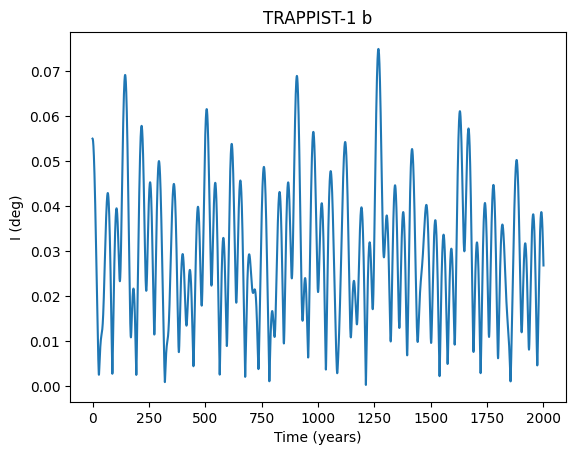

0.005 0.005000000000000002


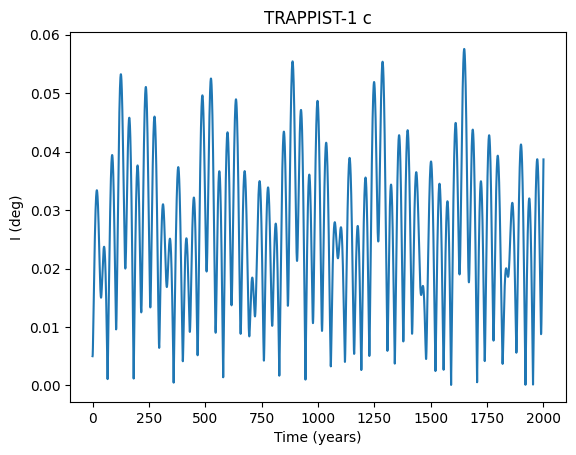

0.113 0.113


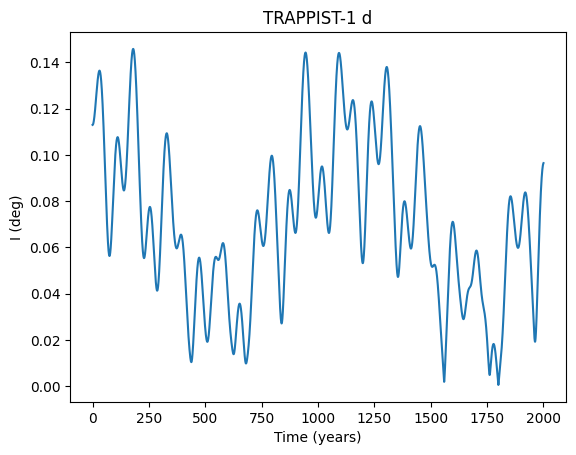

0.01 0.009999999999999998


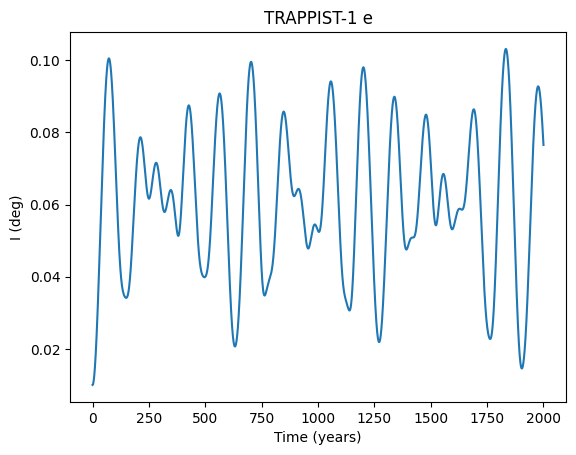

0.043 0.04299999999999999


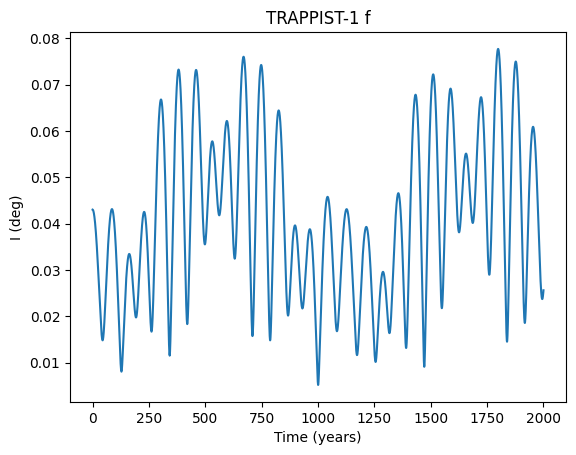

0.04100000000000001 0.041


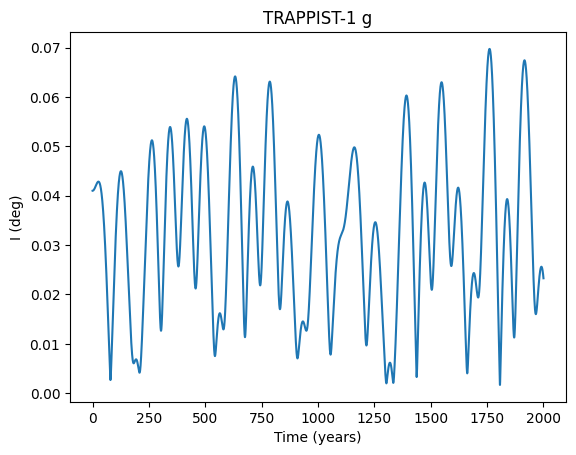

0.022 0.022000000000000002


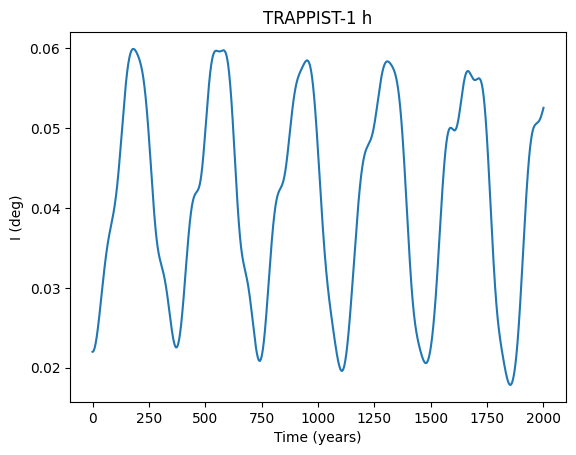

In [18]:
iterations = 10**5
timeline = np.linspace(0,2000,iterations)

p_time = np.zeros([number_of_planets,iterations])
q_time = np.zeros([number_of_planets,iterations])

for i in range(iterations):
    p_time[:,i] = np.matmul(eigvecs_B,T*np.sin(eigvals_B*timeline[i]*(pi/180) ))
    q_time[:,i] = np.matmul(eigvecs_B,T*np.cos(eigvals_B*timeline[i]*(pi/180) ))

I_time = np.sqrt(p_time**2 + q_time**2) #rad


for i in range(len(I_time)):
    print(initialI[i]*(180/pi),I_time[i,0]*(180/pi))
    plt.plot(timeline,I_time[i]*(180/pi)) #deg
    plt.xlabel('Time (years)')
    plt.ylabel('I (deg)')
    plt.title(Table1['Planet Name'][i])
    #plt.savefig(f"../New results/Initial_condition_inclination/{Table1['Planet Name'][i]}.png")
    plt.show()

# Calculating Histories of eccentricity

0.0030547340309755285 0.003054734030975529


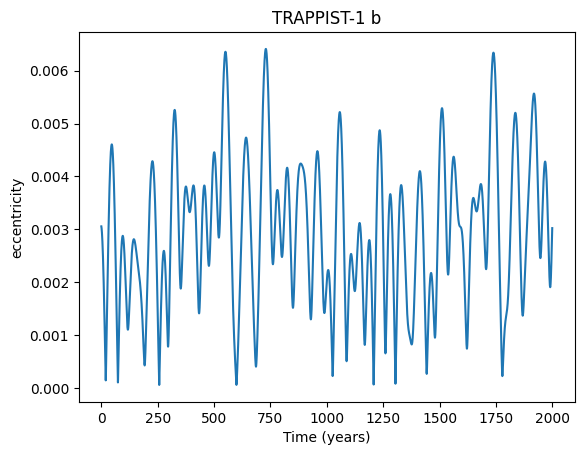

0.0005500909015790027 0.0005500909015790023


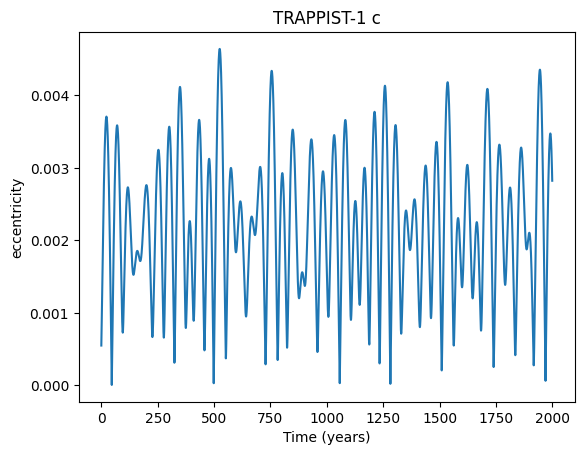

0.005632983223834418 0.0056329832238344165


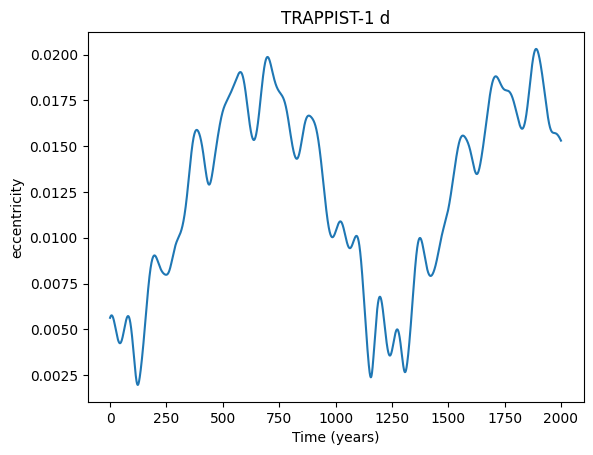

0.006324634376784164 0.006324634376784165


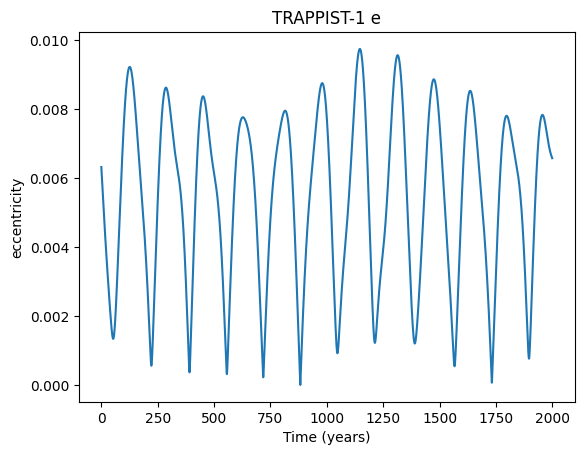

0.008415467901430081 0.008415467901430081


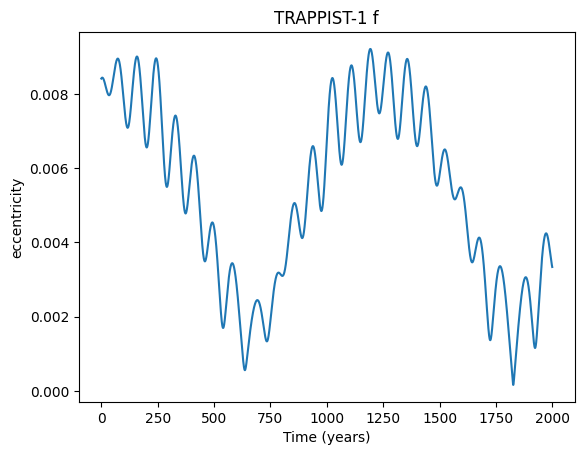

0.004009788024322483 0.0040097880243224835


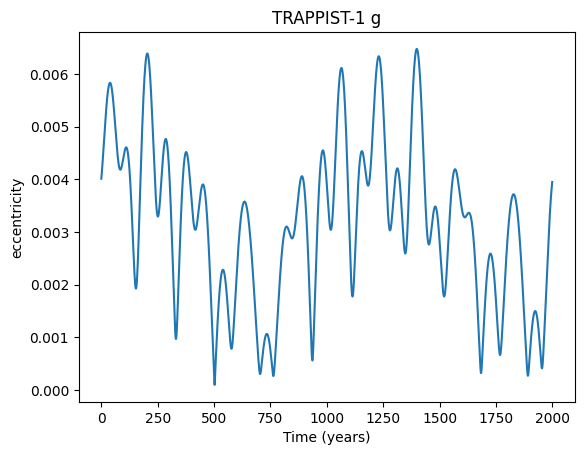

0.003650054794109261 0.0036500547941092617


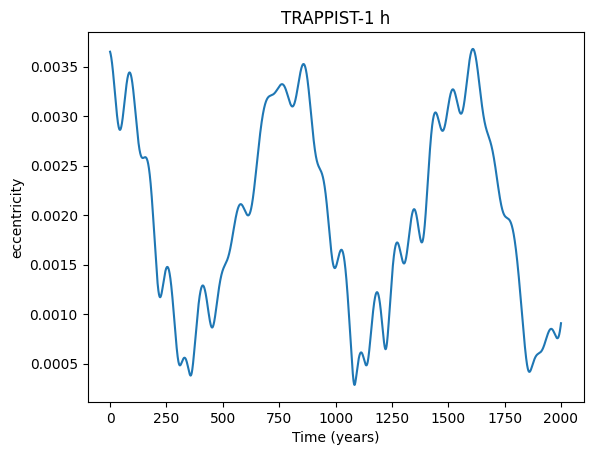

In [19]:
iterations = 10**5
timeline = np.linspace(0,2000,iterations)

h_time = np.zeros([number_of_planets,iterations])
k_time = np.zeros([number_of_planets,iterations])

for i in range(iterations):
    h_time[:,i] = np.matmul(eigvecs_A,S*np.sin(eigvals_A*timeline[i]*(pi/180) + beta))
    k_time[:,i] = np.matmul(eigvecs_A,S*np.cos(eigvals_A*timeline[i]*(pi/180) + beta))

e_time = np.sqrt(h_time**2 + k_time**2)

for i in range(len(e_time)):
    print(initiale[i],e_time[i,0])
    plt.plot(timeline,e_time[i])
    plt.xlabel('Time (years)')
    plt.ylabel('eccentricity') 
    plt.title(Table1['Planet Name'][i])
     #plt.savefig(f"../New results/Initial_condition_ecc/{Table1['Planet Name'][i]}.png")
    plt.show()

# Tables for eigenmodes

In [21]:
## tables of Inclination
data = {
    'Name': ['TRAPPIST-1 b','TRAPPIST-1 c','TRAPPIST-1 d',
                    'TRAPPIST-1 e','TRAPPIST-1 f','TRAPPIST-1 g'
                    ,'TRAPPIST-1 h'] ,
    'Mode 1' : eigvecs_B[:,0],
    'Mode 2' : eigvecs_B[:,1],
    'Mode 3' : eigvecs_B[:,2],
    'Mode 4' : eigvecs_B[:,3],
    'Mode 5' : eigvecs_B[:,4],
    'Mode 6' : eigvecs_B[:,5],
    'Mode 7' : eigvecs_B[:,6],
    }
Table2 = pd.DataFrame(data=data)
data = {
    'Name' : ['Frequency(deg/yr)'],
    'Mode 1' : eigvals_B[0],
    'Mode 2' : eigvals_B[1],
    'Mode 3' : eigvals_B[2],
    'Mode 4' : eigvals_B[3],
    'Mode 5' : eigvals_B[4],
    'Mode 6' : eigvals_B[5],
    'Mode 7' : eigvals_B[6],
}
Table3 = pd.DataFrame(data=data)

period = abs(360/eigvals_B)
data = {
    'Name' : ['Period(years)'],
    'Mode 1' : period[0],
    'Mode 2' : period[1],
    'Mode 3' : period[2],
    'Mode 4' : period[3],
    'Mode 5' : period[4],
    'Mode 6' : period[5],
    'Mode 7' : period[6],
}
Table4 = pd.DataFrame(data=data)
Table_dummy = pd.concat([Table2,Table3],ignore_index=True)
Table_eig_B = pd.concat([Table_dummy,Table4],ignore_index=True)
Table_eig_B.style.hide(axis='index')

In [22]:
## Eigentables of eccentricity
data = {
    'Name': ['TRAPPIST-1 b','TRAPPIST-1 c','TRAPPIST-1 d',
                    'TRAPPIST-1 e','TRAPPIST-1 f','TRAPPIST-1 g'
                    ,'TRAPPIST-1 h'] ,
    'Mode 1' : eigvecs_A[:,0],
    'Mode 2' : eigvecs_A[:,1],
    'Mode 3' : eigvecs_A[:,2],
    'Mode 4' : eigvecs_A[:,3],
    'Mode 5' : eigvecs_A[:,4],
    'Mode 6' : eigvecs_A[:,5],
    'Mode 7' : eigvecs_A[:,6],
    }
Table2 = pd.DataFrame(data=data)
data = {
    'Name' : ['Frequency(deg/yr)'],
    'Mode 1' : eigvals_A[0],
    'Mode 2' : eigvals_A[1],
    'Mode 3' : eigvals_A[2],
    'Mode 4' : eigvals_A[3],
    'Mode 5' : eigvals_A[4],
    'Mode 6' : eigvals_A[5],
    'Mode 7' : eigvals_A[6],
}
Table3 = pd.DataFrame(data=data)

period = abs(360/eigvals_A)
data = {
    'Name' : ['Period(years)'],
    'Mode 1' : period[0],
    'Mode 2' : period[1],
    'Mode 3' : period[2],
    'Mode 4' : period[3],
    'Mode 5' : period[4],
    'Mode 6' : period[5],
    'Mode 7' : period[6],
}
Table5 = pd.DataFrame(data=data)
Table_dummy = pd.concat([Table2,Table3],ignore_index=True)
Table_eig_A = pd.concat([Table_dummy,Table5],ignore_index=True)
Table_eig_A.style.hide(axis='index')

# Calculating mantle density and core radius

### Expression for M.O.I. 

$$
    A_{f} = \frac{8 \pi}{3} \int^{r_{f}}_{0} \rho_{f} [ r^{4} - \frac{1}{15} \frac{\partial}{\partial r} (r^{5}f(r)) ] dr
    \\
          = \frac{8 \pi}{3} \bigg[ \rho_{f} \int^{r_{f}}_{0} r^{4} dr - \frac{\rho_{f}}{15} \int^{r_{f}}_{0} \partial (r^{5}f(r)) \bigg]
          \\
          \boxed{A_{f} = \frac{8 \pi}{15} \rho_{f} r_{f}^{5}}
$$

Similarly, expression for the mean moment of inertia, A:
$$
    A = A_{f} + \frac{8 \pi}{3} \int_{r_{f}}^{R} \rho_{m} [ r^{4} - \frac{1}{15} \frac{\partial}{\partial r} (r^{5}f(r)) ] dr \\
    \boxed{A = A_{f} + \frac{8 \pi}{15} (\rho_{m}[R^{5} - r_{f}^{5}])} \\
    \boxed{A_{m} = A - A_{f}}
$$

# Table with interior structures and moment of Inertia

In [30]:
data = {
    'Planet Name': ['TRAPPIST-1 b','TRAPPIST-1 c','TRAPPIST-1 d',
                    'TRAPPIST-1 e','TRAPPIST-1 f','TRAPPIST-1 g'
                    ,'TRAPPIST-1 h'] , 
     'Core density (g cm^-3)' : [12.0,12.0,10.0,12.0,12.0,12.0,10.0]
    }
Table2 = pd.DataFrame(data=data)
Table2

Planet Name  Core density (g cm^-3)
0  TRAPPIST-1 b                  12.000
1  TRAPPIST-1 c                  12.000
2  TRAPPIST-1 d                  10.000
3  TRAPPIST-1 e                  12.000
4  TRAPPIST-1 f                  12.000
5  TRAPPIST-1 g                  12.000
6  TRAPPIST-1 h                  10.000

In [36]:
# Calculation of core radius and mantle density

cmf = 0.21 # This is the iron fraction assumed

R = Table1['Radius (10^6 m)']
R = R.to_numpy()
mean_d = Table1['Mean density (g cm^-3)']
rhof = Table2['Core density (g cm^-3)']

Rf = R*(cmf*(mean_d/rhof))**(1/3) #10^6 m
rhom = (mean_d - rhof*(Rf/R)**3)/(1-(Rf/R)**3) # gm cm^-3
Rf = Rf.to_numpy()
rhom = rhom.to_numpy()

If = (8*pi/15)*rhof*(Rf**5) #10^40 g cm^2 == 10^33 kg m^2
I = If + (8*pi/15)*rhom*(R**5 - Rf**5) #10^40 g cm^2
Im = I - If #10^40 g cm^2

data = {
    'Planet Name': ['TRAPPIST-1 b','TRAPPIST-1 c','TRAPPIST-1 d',
                    'TRAPPIST-1 e','TRAPPIST-1 f','TRAPPIST-1 g'
                    ,'TRAPPIST-1 h'] , 
     'Core density (g cm^-3)' : [12.0,12.0,10.0,12.0,12.0,12.0,10.0]
    }
Table2 = pd.DataFrame(data=data)
Table2['Core Radius (10^6 m)'] = Rf
Table2['Mantle density (g cm^-3)'] = rhom
Table2[r'$ I (10^{37} \text{kg} \ \text{m}^{2})$'] = I * 10**-4
Table2[r'$ I_{m} (10^{37} \text{kg} \ \text{m}^{2})$'] = Im * 10**-4
Table2[r'$ I_{c} (10^{37} \text{kg} \ \text{m}^{2})$'] = If * 10**-4
Table2

Planet Name  Core density (g cm^-3)  Core Radius (10^6 m)   
0  TRAPPIST-1 b                  12.000                 3.249  \
1  TRAPPIST-1 c                  12.000                 3.196   
2  TRAPPIST-1 d                  10.000                 2.264   
3  TRAPPIST-1 e                  12.000                 2.584   
4  TRAPPIST-1 f                  12.000                 2.960   
5  TRAPPIST-1 g                  12.000                 3.206   
6  TRAPPIST-1 h                  10.000                 2.136   

   Mantle density (g cm^-3)  $ I (10^{37} \text{kg} \ \text{m}^{2})$   
0                     4.743                                   14.972  \
1                     4.760                                   13.760   
2                     3.787                                    2.097   
3                     4.217                                    5.066   
4                     4.334                                    9.835   
5                     4.365                                   14.624   
6                     3.596                                    1.610   

   $ I_{m} (10^{37} \text{kg} \ \text{m}^{2})$   
0                                       14.244  \
1                                       13.090   
2                                        1.997   
3                                        4.835   
4                                        9.379   
5                                       13.943   
6                                        1.536   

   $ I_{c} (10^{37} \text{kg} \ \text{m}^{2})$  
0                                        0.728  
1                                        0.670  
2                                        0.100  
3                                        0.232  
4                                        0.457  
5                                        0.681  
6                                        0.075

# Rotation rates

In [37]:
day_sec = 86400 #seconds
period_in_seconds = Table1['Period(day)'] * day_sec
period_in_seconds = period_in_seconds.to_numpy()
rot = 2*pi/(period_in_seconds) #rad/sec

rot_ell = np.zeros([number_of_planets])
for i in range(7):
    rot_ell[i] = rot[i]  #rot_ell


## Modified rotation period (for hydrostatic shapes of planets f,g,h)

In [38]:
## Uncomment these lines for non-hydrostatic shapes based on a 6 day period

## Change dynamical ellipticity of planets f,g h: prescribe non-hydrostatic rotation rate (based on a 6 day period)

#period_in_seconds = 6 * day_sec
#rot_ell[4]=2*pi/(period_in_seconds)
#rot_ell[5]=2*pi/(period_in_seconds)
#rot_ell[6]=2*pi/(period_in_seconds)

print(rot)
print(rot_ell)

[4.81339692e-05 3.00264013e-05 1.79595256e-05 1.19196684e-05
 7.89809788e-06 5.88725927e-06 3.87378529e-06]
[4.81339692e-05 3.00264013e-05 1.79595256e-05 1.19196684e-05
 7.89809788e-06 5.88725927e-06 3.87378529e-06]


# Computing dynamical ellipticity

In [39]:
def rhs_clairaut(y,x,xcmb,rhof,rhom):
    if x < xcmb:
        dydx = np.array([ y[1] , -(6/x)*y[1]])
    else:
        zeta = rhom/(rhom + (rhof-rhom)*(xcmb/x)**3)
        dydx = np.array([ y[1], (-6/x)*zeta*y[1] - 
                         6/(x**2) * (zeta - 1) * y[0]])
    return dydx

In [40]:
def shoot_clairaut_homog(v,mm,rhom,rhof,xcmb):
    y0 = [float(v),0.0]
    xx = np.linspace(xcmb, 1, 201)
    yy = odeint(rhs_clairaut,y0,xx,args=(xcmb,rhof,rhom))
    
    nx = len(xx) - 1
    
    f = yy[nx,1] + 2*yy[nx,0] - (25/4)*mm
    return f,yy

In [41]:
def clairaut_homog(mm,rhom,rhof,xcmb):
    v0 = 0.001
    
    def func(x):
        f,yy = shoot_clairaut_homog(x,mm,rhom,rhof,xcmb)
        return f
    
    v = fsolve(func,v0)
    
    f,yy = shoot_clairaut_homog(v,mm,rhom,rhof,xcmb)
    
    ellf = v
    
    flat = yy[-1,0]
    ell = (rhof*xcmb**5*ellf + rhom*(flat-ellf*xcmb**5))/(rhof*xcmb**5 + 
                                                         rhom*(1-xcmb**5))
    return ellf,ell,flat

## Fluid core & whole planet ellipticities 

In [42]:
### Assuming rotation frequency = orbital frequency
G = 6.67430 * 10**-8 # cm^3 g^-1 s^-2
xcmb = Rf/R
mm = (rot_ell**2 * R**3)/(G*M*(10**3))
print(rot)
print(rot_ell)
print(mm)
ell = np.zeros((len(rot)))
ellf = np.zeros((len(rot)))
flat = np.zeros((len(rot)))

for i in range(len(rot)):
    ellf[i],ell[i],flat[i] = clairaut_homog(mm[i],rhom[i],rhof[i],xcmb[i])

[4.81339692e-05 3.00264013e-05 1.79595256e-05 1.19196684e-05
 7.89809788e-06 5.88725927e-06 3.87378529e-06]
[4.81339692e-05 3.00264013e-05 1.79595256e-05 1.19196684e-05
 7.89809788e-06 5.88725927e-06 3.87378529e-06]
[1.52531154e-03 5.91685047e-04 2.64918870e-04 1.04095662e-04
 4.45761421e-05 2.46073422e-05 1.29203923e-05]


In [45]:
data = {
    'Planet Name': ['TRAPPIST-1 b','TRAPPIST-1 c','TRAPPIST-1 d',
                    'TRAPPIST-1 e','TRAPPIST-1 f','TRAPPIST-1 g'
                    ,'TRAPPIST-1 h']
    }
Table3 = pd.DataFrame(data=data)
Table3[r'$ \epsilon (\times 10^{-4})$'] = flat * 10**4
Table3[r'$ \alpha (\times 10^{-4})$'] = ell * 10**4
Table3[r'$ \alpha_{c} (\times 10^{-4})$'] = ellf * 10**4
Table3

Planet Name  $ \epsilon (\times 10^{-4})$  $ \alpha (\times 10^{-4})$   
0  TRAPPIST-1 b                        40.999                      40.641  \
1  TRAPPIST-1 c                        15.911                      15.772   
2  TRAPPIST-1 d                         7.085                       7.020   
3  TRAPPIST-1 e                         2.761                       2.733   
4  TRAPPIST-1 f                         1.186                       1.174   
5  TRAPPIST-1 g                         0.655                       0.649   
6  TRAPPIST-1 h                         0.344                       0.340   

   $ \alpha_{c} (\times 10^{-4})$  
0                          28.809  
1                          11.200  
2                           4.866  
3                           1.820  
4                           0.794  
5                           0.440  
6                           0.229

# Planetary Libration

In [46]:
I_eps = ((8*pi)/15)*(rhom*(R**5)*ell + (rhof - rhom)*(Rf**5)*ellf) #10^40 g cm^2
I_zeta = (6/5)*I_eps #10^40 g cm^2; for a planet in a 1:1 spin-orbit resonance

[[4.81339692e-05]
 [3.00264013e-05]
 [1.79595256e-05]
 [1.19196684e-05]
 [7.89809788e-06]
 [5.88725927e-06]
 [3.87378529e-06]]
[[0.03349912]
 [0.0861961 ]
 [0.21620399]
 [0.52278895]
 [1.20309588]
 [2.17111352]
 [4.55777781]]


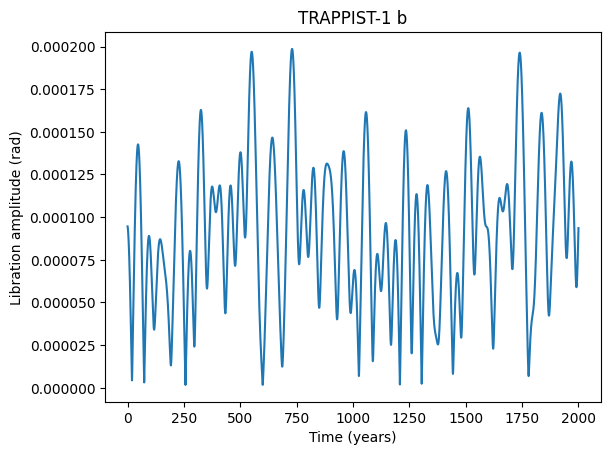

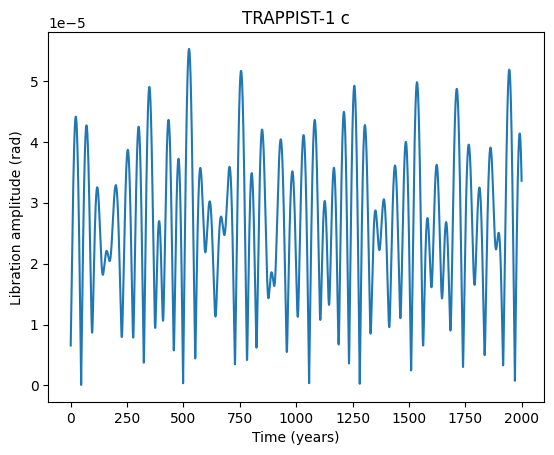

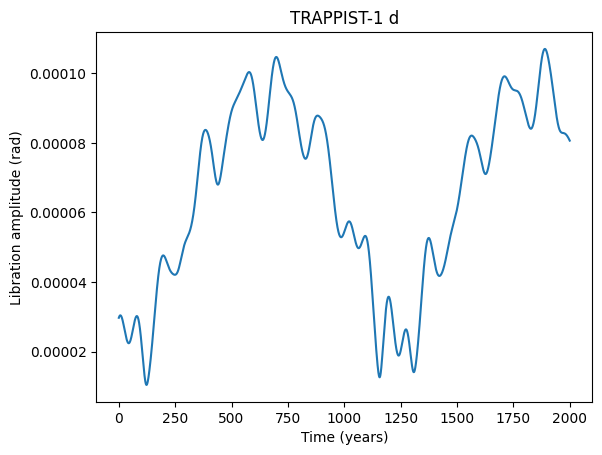

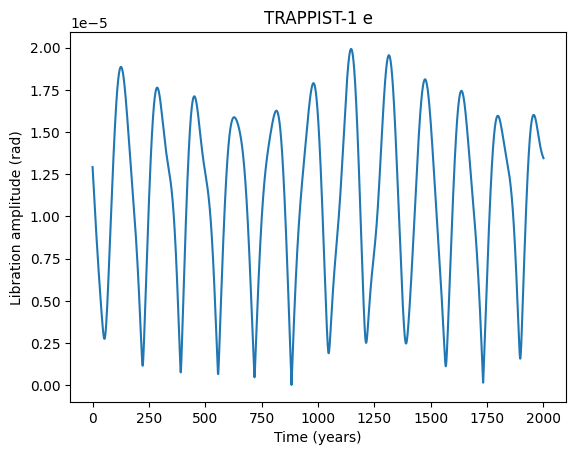

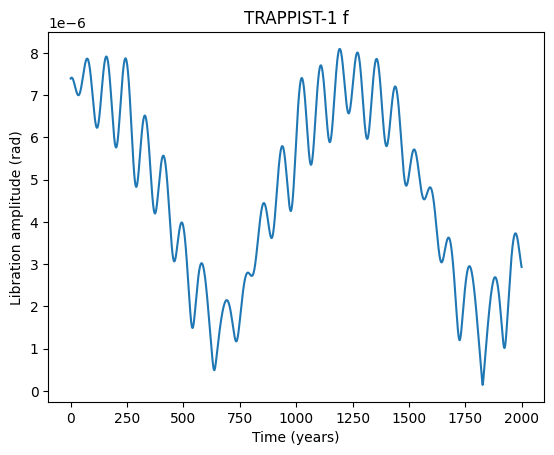

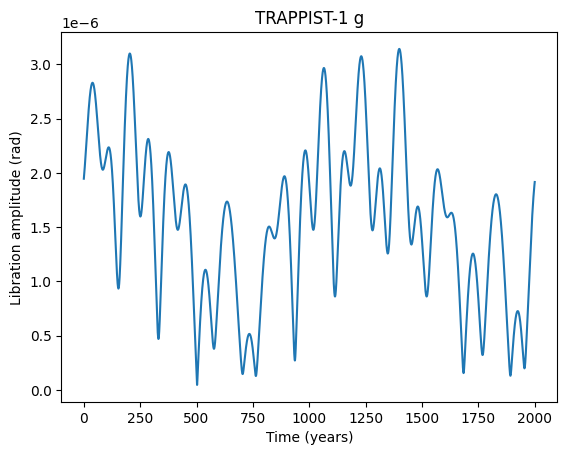

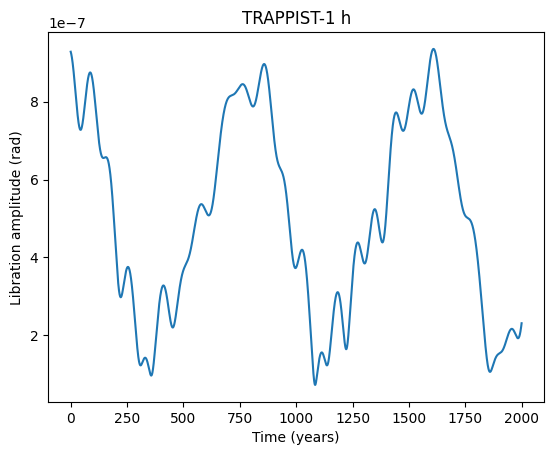

In [52]:
iterations = 10**5
#number_of_planets = len(Table2['Planet Name'])
timeline = np.linspace(0,2000,iterations)
factor = 3.0*(I_zeta/Im)
rot_rate = np.reshape(rot, (7, -1)) #rad/sec
factor = np.reshape(factor,(7,-1))
print(rot_rate)

lib_freq = rot_rate*np.sqrt(factor)
T_lib = 2*pi/lib_freq/365.25/86400
print(T_lib)
lib_amplitude = ((2*lib_freq**2)/(rot_rate**2 - lib_freq**2))*e_time
    
    
for i in range(len(lib_freq)):
    plt.plot(timeline,lib_amplitude[i])
    plt.xlabel('Time (years)')
    plt.ylabel('Libration amplitude (rad)')
    plt.title(Table1['Planet Name'][i])
    plt.show()

# Plotting

In [53]:
#fig, ax1 = plt.subplots()
#plt.figure(figsize=(6,4))
#plt.plot(timeline,e_time[4])
#plt.xlabel('Time(years)')
#plt.ylabel('e',color='b')
#ax2 = ax1.twinx()
#ax2.plot(timeline,lib_amplitude[4],'r')
#plt.ylabel('Libration Amplitude',color='r')
#plt.show()

In [54]:
#fig, ax1 = plt.subplots()
#t = np.arange(0.01, 10.0, 0.01)
#s1 = np.exp(t)
#plt.plot(t,s1,'b-')
#plt.xlabel('t (s)')
#plt.ylabel('exp',color='b')
#
#ax2 = ax1.twinx()
#s2 = np.sin(2*np.pi*t)
#ax2.plot(t, s2, 'r.')
#plt.ylabel('sin', color='r')
#plt.show()

# Mean libration Amplitude over 10k years

In [62]:
iterations = 10**5
timeline = np.linspace(0,10000,iterations)
#timeline = np.linspace(0,2000,iterations)   # change to this for plots in the paper

h_time = np.zeros([number_of_planets,iterations])
k_time = np.zeros([number_of_planets,iterations])

for i in range(iterations):
    h_time[:,i] = np.matmul(eigvecs_A,S*np.sin(eigvals_A*timeline[i]*(pi/180) + beta))
    k_time[:,i] = np.matmul(eigvecs_A,S*np.cos(eigvals_A*timeline[i]*(pi/180) + beta))

e_time10 = np.sqrt(h_time**2 + k_time**2)

lib_amplitude = ((2*lib_freq**2)/(rot_rate**2 - lib_freq**2))*e_time10
    
mean_lib_amp = []
for i in range(len(lib_freq)):
    mean_lib_amp.append(np.mean(lib_amplitude[i]))
    
#print(mean_lib_amp)    
mean_lib_amp = np.array(mean_lib_amp)
mean_lib_amp = mean_lib_amp.reshape((7,1))

#print(mean_lib_amp)

Rfmeter=(10**6)*Rf
Rfmeter=Rfmeter.reshape((7,1))

visc=10**-6
delta_vskin=np.sqrt(visc/rot_rate)

Relib=Rfmeter*mean_lib_amp/delta_vskin
print(delta_vskin)
print(Rfmeter)
print(mean_lib_amp)
print(Relib)



[[0.14413656]
 [0.1824939 ]
 [0.23596771]
 [0.28964625]
 [0.35582687]
 [0.41213872]
 [0.50808015]]
[[3249240.29549713]
 [3196006.216811  ]
 [2264417.03559204]
 [2584460.60987003]
 [2959582.21194697]
 [3206334.39781369]
 [2136404.23580333]]
[[8.99563214e-05]
 [2.66120957e-05]
 [6.40718330e-05]
 [1.11450270e-05]
 [4.84399555e-06]
 [1.57806580e-06]
 [5.16883548e-07]]
[[2027.86647637]
 [ 466.05624655]
 [ 614.85256882]
 [  99.44504039]
 [  40.28982676]
 [  12.27695042]
 [   2.17342127]]


# Libration Dissipation

[6.19460571e+08 1.49461159e+07 4.97963840e+06 1.15012980e+05
 1.29476031e+04 9.20056653e+02 5.75908455e+00]
[5.74124952e+09 2.96861037e+07 1.26675212e+07 4.95305028e+04
 2.19086434e+03 4.91725109e+01 5.43672103e-02]


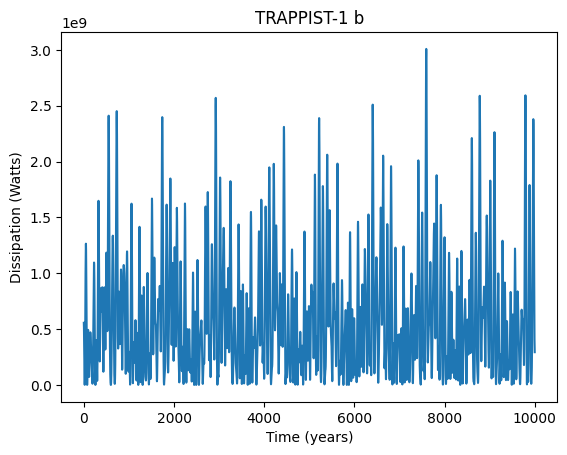

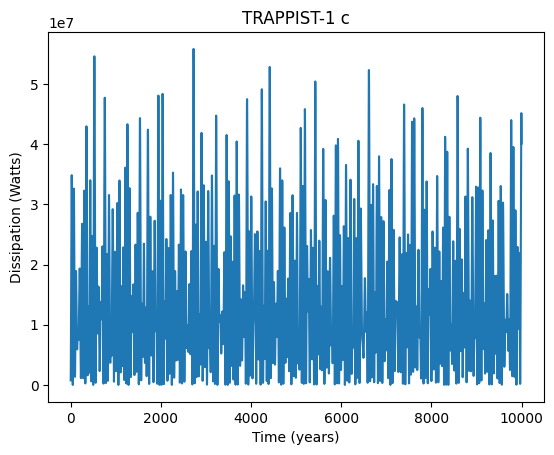

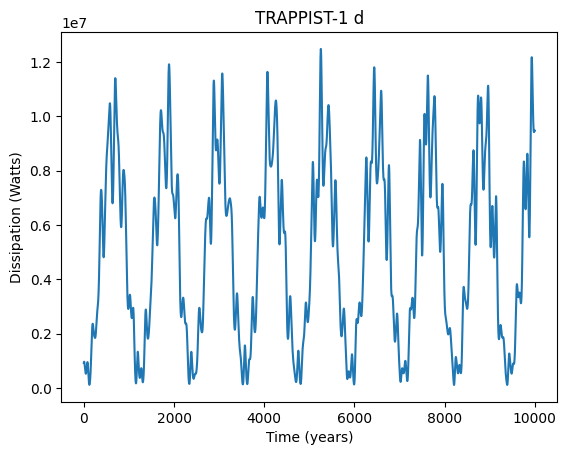

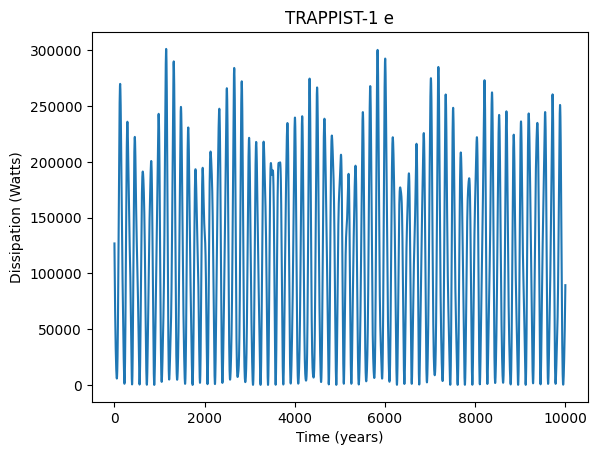

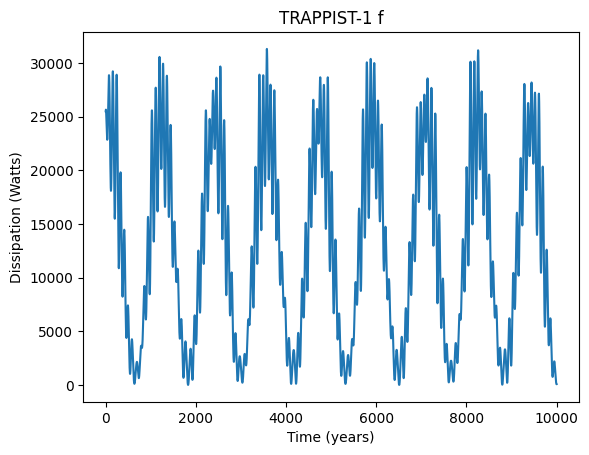

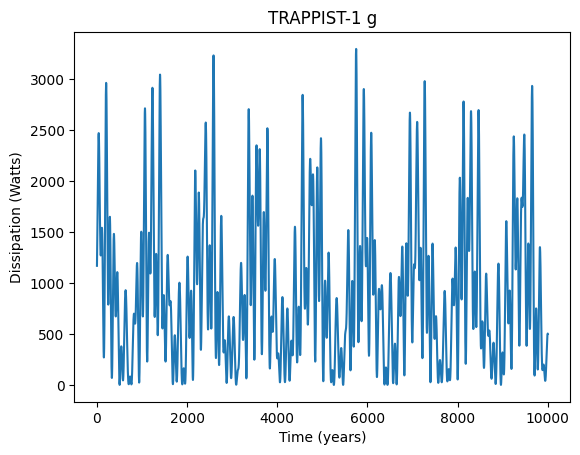

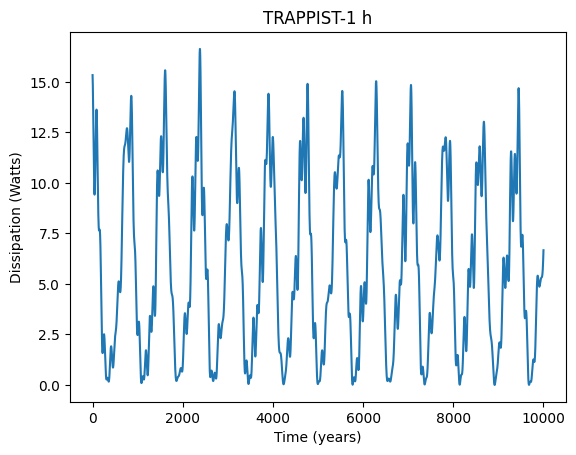

In [63]:
rhof = np.reshape(rhof, (7, -1)) #g/cm^3
Rf = np.reshape(Rf, (7, -1)) #10^8 cm
K = 1.726
v = 10**-6
cl = 0.003
lib_diss = (8*pi/15)*K*rhof*(Rf**4)*np.sqrt(v*rot_rate)*(rot_rate**2)*(lib_amplitude**2)*10**27
lib_diss_turb = cl*pi*rhof*(Rf**5)*(rot_rate**3)*(lib_amplitude**3)*10**33

mean_lib_diss = []
mean_lib_diss_turb = []
for i in range(len(lib_freq)):
    mean_lib_diss.append(np.mean(lib_diss[i]))
    mean_lib_diss_turb.append(np.mean(lib_diss_turb[i]))
    
mean_lib_diss = np.array(mean_lib_diss)
print(mean_lib_diss)

mean_lib_diss_turb = np.array(mean_lib_diss_turb)
print(mean_lib_diss_turb)

for i in range(len(lib_freq)):
    plt.plot(timeline,lib_diss[i])
    plt.xlabel('Time (years)')
    plt.ylabel('Dissipation (Watts)')
    plt.title(Table1['Planet Name'][i])
    plt.show()

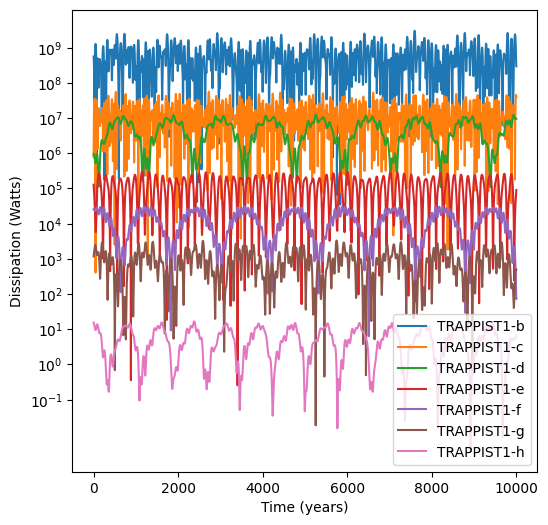

In [64]:
# Figure of dissipation 

plt.figure(figsize=(6,6))
plt.semilogy(timeline,lib_diss[0],label=r'TRAPPIST1-b')
plt.semilogy(timeline,lib_diss[1],label=r'TRAPPIST1-c')
plt.semilogy(timeline,lib_diss[2],label=r'TRAPPIST1-d')
plt.semilogy(timeline,lib_diss[3],label=r'TRAPPIST1-e')
plt.semilogy(timeline,lib_diss[4],label=r'TRAPPIST1-f')
plt.semilogy(timeline,lib_diss[5],label=r'TRAPPIST1-g')
plt.semilogy(timeline,lib_diss[6],label=r'TRAPPIST1-h')
plt.xlabel('Time (years)')
plt.ylabel('Dissipation (Watts)')
plt.yticks([0.1,1,10,100,10**3,10**4,10**5,10**6,10**7,10**8,10**9])
#plt.yscale("log")
#plt.savefig("lib_dissip.pdf", format="pdf", bbox_inches="tight")
plt.legend()
plt.show()

In [69]:
data = {
    'Name': ['TRAPPIST-1 b','TRAPPIST-1 c','TRAPPIST-1 d',
                    'TRAPPIST-1 e','TRAPPIST-1 f','TRAPPIST-1 g'
                    ,'TRAPPIST-1 h']
}
pd.options.display.float_format = '{:.3e}'.format
Table6 = pd.DataFrame(data=data)
Table6[r'$\gamma_o$ (rad)'] = mean_lib_amp 
Table6[r'$Re_{lib}$'] = Relib
Table6[r'${\cal D}_{lib}^{lam}$ (W)'] = mean_lib_diss
Table6[r'${\cal D}_{lib}^{tur}$ (W)'] = mean_lib_diss_turb
Table6.style.hide(axis='index')
Table6

Name  $\gamma_o$ (rad)  $Re_{lib}$  ${\cal D}_{lib}^{lam}$ (W)   
0  TRAPPIST-1 b         8.996e-05   2.028e+03                   6.195e+08  \
1  TRAPPIST-1 c         2.661e-05   4.661e+02                   1.495e+07   
2  TRAPPIST-1 d         6.407e-05   6.149e+02                   4.980e+06   
3  TRAPPIST-1 e         1.115e-05   9.945e+01                   1.150e+05   
4  TRAPPIST-1 f         4.844e-06   4.029e+01                   1.295e+04   
5  TRAPPIST-1 g         1.578e-06   1.228e+01                   9.201e+02   
6  TRAPPIST-1 h         5.169e-07   2.173e+00                   5.759e+00   

   ${\cal D}_{lib}^{tur}$ (W)  
0                   5.741e+09  
1                   2.969e+07  
2                   1.267e+07  
3                   4.953e+04  
4                   2.191e+03  
5                   4.917e+01  
6                   5.437e-02

# Computing Obliquities

### Glossary

1) $\epsilon_{m}$: Obliquity of the mantle
2) $\theta_{m}$: Small offset of the rotation vector with respect to the mantle orientation
3) $\theta_{f}$: Offset of the spin of the fluid core with respect to the mantle spin vector
4) $\theta_{m} + \theta_{f}$: Angle of offset between the spin axis of the fluid core and the mantle symmetry axis.

## Time evolution of orbital inclination angle 

\begin{equation}
I_{j}(t) = \Sigma_{k=1}^{N-1} c_{k}v_{jk}exp(i\Omega_{pk}t + \gamma_{k}) \\
\epsilon_{m}^{j}(t) = \Sigma_{k=1}^{N-1} \epsilon^{jk}_{m} exp(i\Omega_{pk}t) \\
\theta_{f}^{j}(t) = \Sigma_{k=1}^{N-1} \theta^{jk}_{f} exp(i\Omega_{pk}t) \\
\end{equation}

\begin{equation}
\text{The eigenvectors used here are scaled.}
\end{equation}

In [70]:
def non_linear_system(var,*data):

    A = data[0][0]
    Af = data[0][1]
    ell = data[0][2]
    ellf = data[0][3]
    Incl = data[0][4]
    dsigma = data[0][5]
    
#    print(A,Af,ell,ellf,Incl,dsigma)
    
    theta_m = var[0]
    theta_f = var[1]
    ep_m = var[2]
    
    s = - 1.0 + cos(Incl + ep_m)*dsigma

    sIem = sin(Incl + ep_m)
    cIem = cos(Incl + ep_m)
    x12 = theta_m + theta_f
    s12 = sin(x12) - sin(theta_m)
    c12 = cos(x12) - cos(theta_m)
    
    F = np.empty(3)
    
    Flin = (s - ell*cos(theta_m))*sin(theta_m) + (Af/A)*(s*s12 + sin(theta_f) - ellf*sin(theta_m)*c12)
    
    F[0] = Flin + 1.5*ell*sin(ep_m)*(13.0/10.0*cos(ep_m) + 0.3)
    F[1] = (sin(theta_f) + s*sin(x12) + ellf*cos(x12)*s12)
    F[2] = s*sin(Incl + ep_m) + sin(theta_m + Incl + ep_m)
    
    return F

seed(1)
nicond = 101
scale = pi/180.0
sec_to_year = 3.17098*(10**-8)

number_of_planets = 7

theta_m = np.zeros((number_of_planets,nicond))
theta_f = np.zeros((number_of_planets,nicond))
ep_m = np.zeros((number_of_planets,nicond))

theta_m0 = np.zeros([number_of_planets,number_of_planets])
theta_f0 = np.zeros([number_of_planets,number_of_planets])
ep_m0 = np.zeros([number_of_planets,number_of_planets])

T_fp = []
T_fcn = []

### test
#j=0  # planet b
#A1 = I[j]
#Af1 = If[j]
#Am1 = Im[j]
#ell1 = ell[j]
#ellf1 = ellf[j]
#rot1 = rot[j] #rad/s
#rot_degree_per_year = rot1 * (180/pi) * (1/sec_to_year) #deg/year
#
#print(A1,Af1,Am1,ell1,ellf1,rot1)
#
### end test

for j in range(number_of_planets):
#for j in range(1):

    A1 = I[j]
    Af1 = If[j]
    Am1 = Im[j]
    ell1 = ell[j]
    ellf1 = ellf[j]
    rot1 = rot[j] #rad/s
    rot_degree_per_year = rot1 * (180/pi) * (1/sec_to_year) #deg/year
        
    l_fpr = ell1*(3.0/2.0)*(16.0/10.0)

    w_fp = rot1*(A1/Am1)*(ellf1 + l_fpr)*((1.0/2.0) + (1.0/2.0)*(1.0-4.0*(Am1/A1)*(
    (ellf1*l_fpr)/((ellf1 + l_fpr)**2)))**(1/2)) #rad/sec

    T_fp.append((2.0*pi)/w_fp)
    
    w_fcn = rot1*(A1/Am1)*(ellf1 + l_fpr)*((1.0/2.0) - (1.0/2.0)*(1.0-4.0*(Am1/A1)*(
    (ellf1*l_fpr)/((ellf1 + l_fpr)**2)))**(1/2)) #rad/sec

    T_fcn.append((2.0*pi)/w_fcn)
    
    
    for k in range(number_of_planets):
#    for k in range(1):
        Incl = T[k]*eigvecs_B[j,k] #scaling & rad, starting with a specific row 
        dsigma = eigvals_B[k]/rot_degree_per_year
#        print(j,k,dsigma,Incl*180/pi)
        xmin = - 90*scale
        xmax = 90*scale
        x0 = np.zeros((3,1))
        sol = np.zeros((3))

        for i in range(nicond):

            x0[0,0] = 10**-4 #rad
            x0[1,0] = (xmin + (xmax-xmin)*np.random.random(1)) #rad
            x0[2,0] = (xmin + (xmax-xmin)*np.random.random(1)) #rad

            data = np.array([A1,Af1,ell1,ellf1,Incl,dsigma])
            sol,info,ier,msg = fsolve(non_linear_system,x0,args=data,full_output=True,maxfev=50,xtol=10**-12)

            if (ier != 1):
                sol[:] = 10**3

            if (sol[1] < xmin) or (sol[1] > xmax):
                sol[:] = 10**3

            if (sol[2] < -88.0*scale) or (sol[2] > 88.0*scale):
                sol[:] = 10**3

            theta_m[k,i] = sol[0]/scale #deg
            theta_f[k,i] = sol[1]/scale #deg
            ep_m[k,i] = sol[2]/scale #deg
#            print(i,theta_f[k,i],ep_m[k,i])
            
        min_theta_f = min(abs(theta_f[k,:]))
        min_index = np.argmin(abs(theta_f[k,:]))
#        print(min_index)
        
        theta_f0[j,k] = theta_f[k,min_index]
        theta_m0[j,k] = theta_m[k,min_index]
        ep_m0[j,k] = ep_m[k,min_index]
        
T_fcn = np.array(T_fcn)
T_fp = np.array(T_fp)

print(T_fp/365.25/86400)
print(T_fcn/365.25/86400)
#print(ep_m0)

[3.95614124e-01 1.63385855e+00 6.15151517e+00 2.38898670e+01
 8.38107128e+01 2.03433700e+02 5.89981271e+02]
[1.46428400e+00 6.03808108e+00 2.32119341e+01 9.33701830e+01
 3.23298982e+02 7.82105915e+02 2.28067534e+03]


5 -0.0010570709724676323 -0.611234338358349
[ 4.27466030e-04  4.06134104e-04  2.67835349e-04  4.85005792e-05
 -1.37381610e-04 -2.01480046e-04 -7.97603239e-04]
[ 1.04611751e-06  4.13905189e-06  1.09076800e-05  9.37130688e-06
 -1.91843273e-04  1.22252240e-03 -4.17073307e-01]
[ 3.09518941e-07  1.21490947e-06  3.03640689e-06  2.21341370e-06
 -2.62219913e-05 -8.45437584e-05  3.08314084e-01]


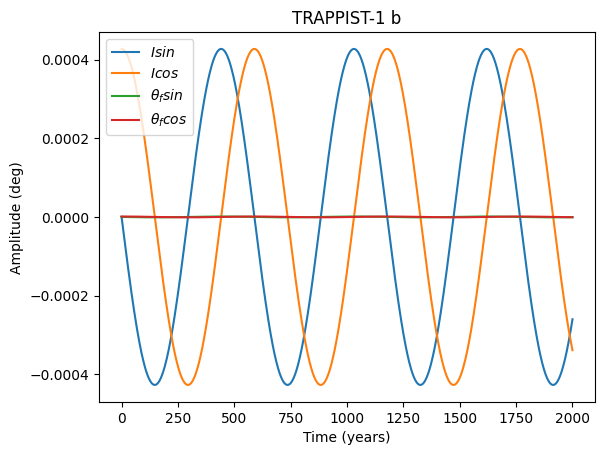

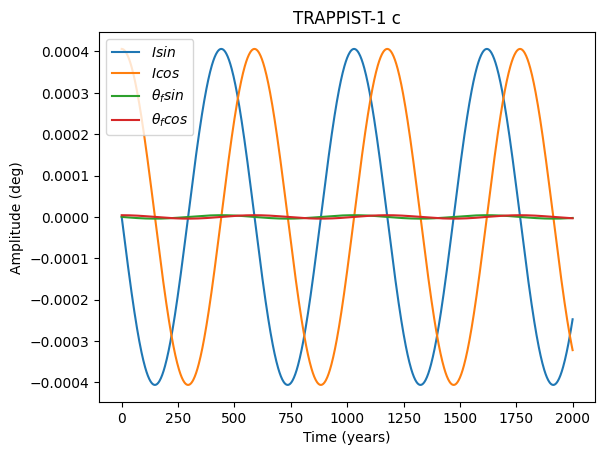

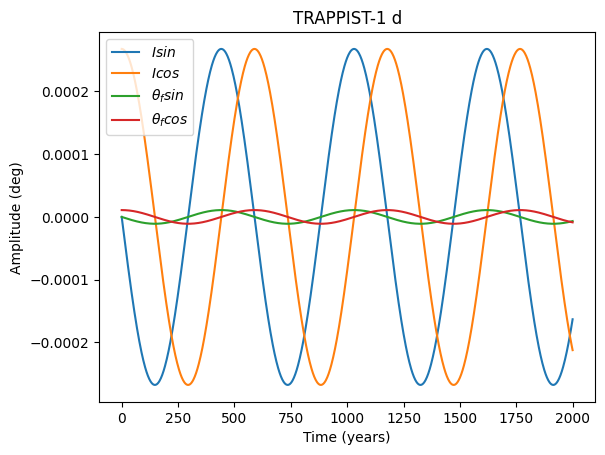

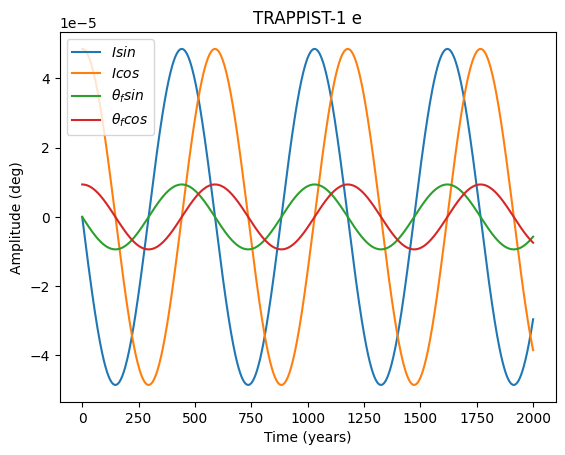

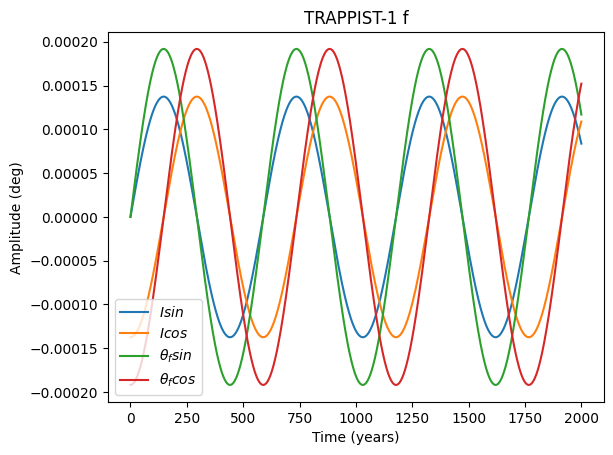

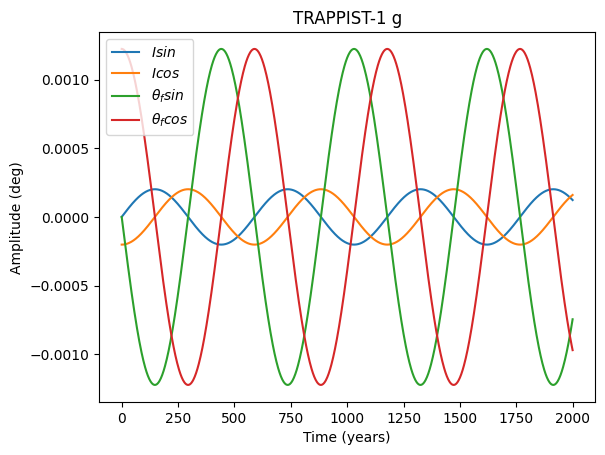

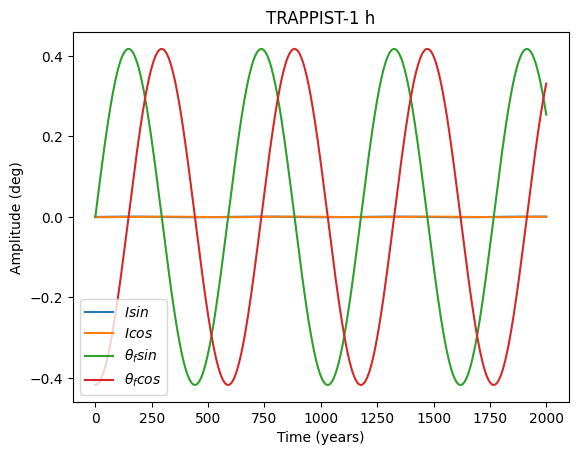

In [86]:
# tests of eigenmodes

iterations = 1001
timeline = np.linspace(0,2000,iterations)

p_f_time = np.zeros([number_of_planets,iterations])
q_f_time = np.zeros([number_of_planets,iterations])

p_m_time = np.zeros([number_of_planets,iterations])
q_m_time = np.zeros([number_of_planets,iterations])

p_time = np.zeros([number_of_planets,iterations])
q_time = np.zeros([number_of_planets,iterations])

indp=5;
Talt=T[indp]*(180/pi);
eigalt=eigvals_B[indp];

print(indp,Talt,eigalt)
print(eigvecs_B[:,indp]*Talt)

print(theta_f0[:,indp])
print(ep_m0[:,indp])

for i in range(iterations):
#    p_time[:,i] = np.matmul(eigvecs_B,T*np.sin(eigvals_B*timeline[i]*(pi/180) ))
#    q_time[:,i] = np.matmul(eigvecs_B,T*np.cos(eigvals_B*timeline[i]*(pi/180) ))
    p_time[:,i] = eigvecs_B[:,indp]*Talt*np.sin(eigalt*timeline[i]*(pi/180) )
    q_time[:,i] = eigvecs_B[:,indp]*Talt*np.cos(eigalt*timeline[i]*(pi/180) )
    
    p_f_time[:,i] = theta_f0[:,indp]*np.sin(eigalt*timeline[i]*(pi/180) )
    q_f_time[:,i] = theta_f0[:,indp]*np.cos(eigalt*timeline[i]*(pi/180) )

for i in range(len(I_time)):
    plt.plot(timeline,p_time[i],label=r'$I sin$')
    plt.plot(timeline,q_time[i],label=r'$I cos$')
    plt.plot(timeline,p_f_time[i],label=r'$\theta_f sin$')
    plt.plot(timeline,q_f_time[i],label=r'$\theta_f cos$')
    plt.xlabel('Time (years)')
    plt.ylabel('Amplitude (deg)')
    plt.title(Table1['Planet Name'][i])
    plt.legend()
    #plt.savefig(f"../New results/inclination,mantle_obl,core_offset/{Table1['Planet Name'][i]}.png")
    plt.show()

In [87]:
#theta_f0 and ep_m0 are is degrees whereas, scaled eigenvectors are
#in radians

iterations = 10**5
timeline = np.linspace(0,10000,iterations)

p_f_time = np.zeros([number_of_planets,iterations])
q_f_time = np.zeros([number_of_planets,iterations])

p_m_time = np.zeros([number_of_planets,iterations])
q_m_time = np.zeros([number_of_planets,iterations])

p_time = np.zeros([number_of_planets,iterations])
q_time = np.zeros([number_of_planets,iterations])

for i in range(iterations):
    p_time[:,i] = np.matmul(eigvecs_B,T*np.sin(eigvals_B*timeline[i]*(pi/180) ))
    q_time[:,i] = np.matmul(eigvecs_B,T*np.cos(eigvals_B*timeline[i]*(pi/180) ))

for i in range(iterations):
    p_f_time[:,i] = np.matmul(theta_f0,np.sin(eigvals_B*timeline[i]*(pi/180) ))
    q_f_time[:,i] = np.matmul(theta_f0,np.cos(eigvals_B*timeline[i]*(pi/180) ))

for i in range(iterations):
    p_m_time[:,i] = np.matmul(ep_m0,np.sin(eigvals_B*timeline[i]*(pi/180) ))
    q_m_time[:,i] = np.matmul(ep_m0,np.cos(eigvals_B*timeline[i]*(pi/180) ))

theta_f_time = np.sqrt(p_f_time**2 + q_f_time**2) #deg
ep_m_time = np.sqrt(p_m_time**2 + q_m_time**2) #deg
I_time = np.sqrt(p_time**2 + q_time**2) #rad

#for i in range(len(I_time)):
#    plt.plot(timeline,p_time[i]*(180/pi),label=r'$I \,\sin$')
#    plt.plot(timeline,q_time[i]*(180/pi),label=r'$I \,\cos$')
#    plt.plot(timeline,I_time[i]*(180/pi),label=r'$I$')
#    plt.plot(timeline,p_f_time[i],label=r'$\theta_f \, \sin$')
#    plt.plot(timeline,q_f_time[i],label=r'$\theta_f \, \cos$')
#    plt.plot(timeline,theta_f_time[i],label=r'$\theta_f$')
#    plt.xlabel('Time (years)')
#    plt.ylabel('Amplitude (deg)')
#    plt.title(Table1['Planet Name'][i])
#    plt.legend()
#    plt.show()
    

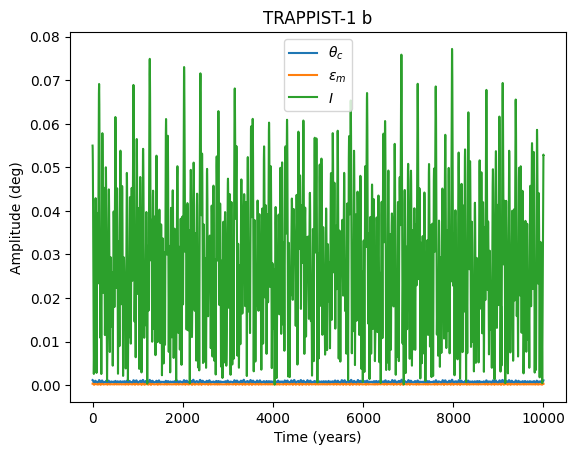

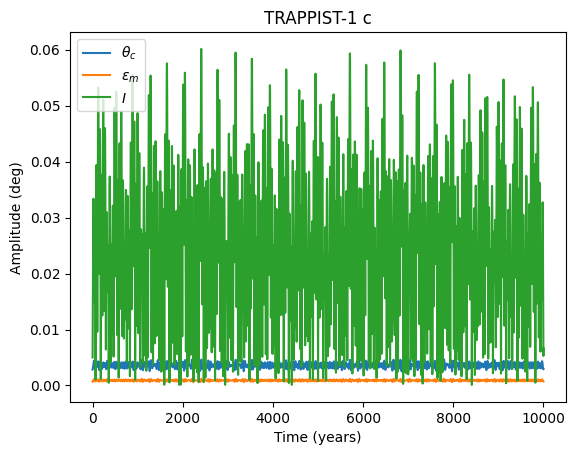

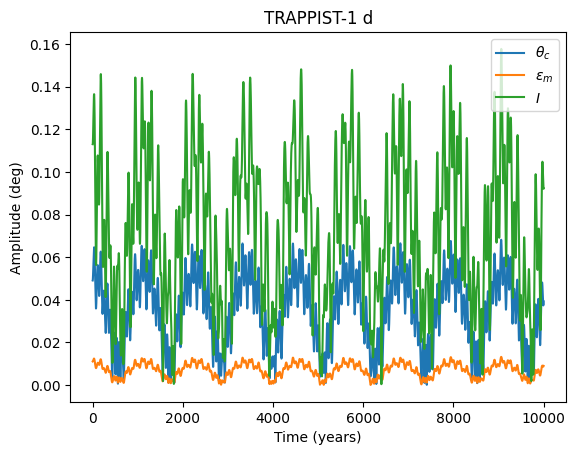

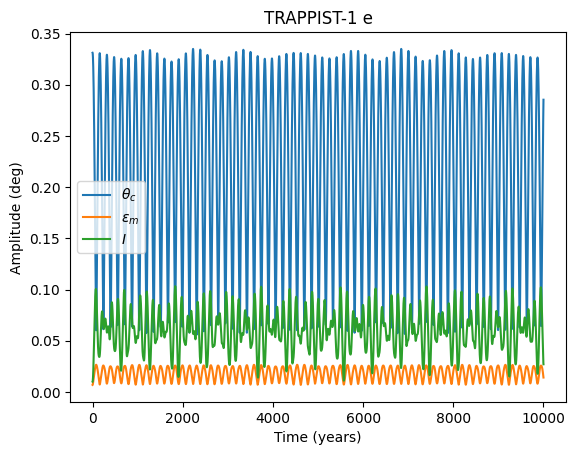

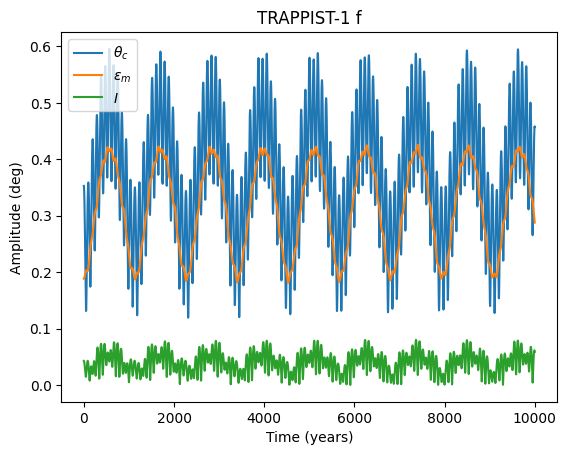

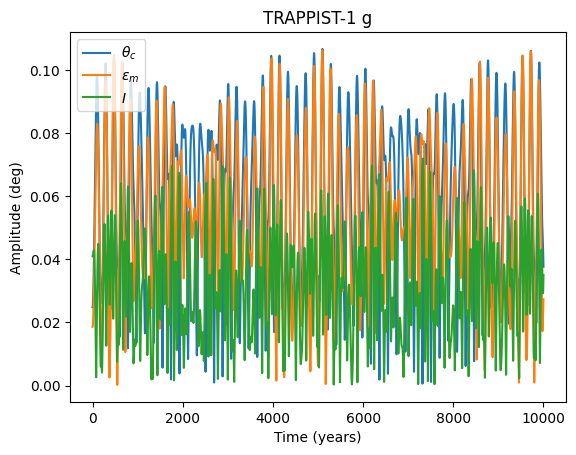

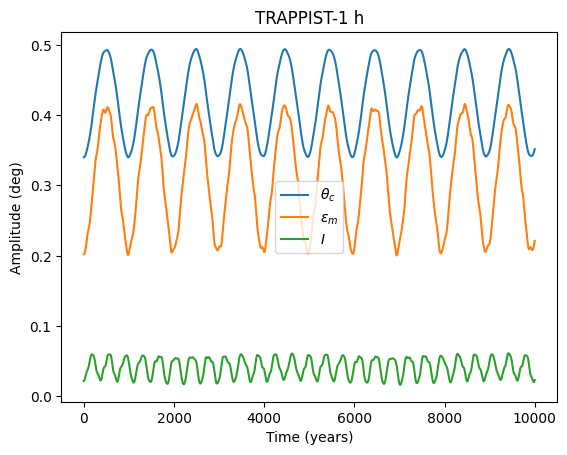

In [88]:
for i in range(len(I_time)):
    plt.plot(timeline,theta_f_time[i],label=r'$\theta_{c}$')
    plt.plot(timeline,ep_m_time[i],label=r'$\epsilon_{m}$')
    plt.plot(timeline,I_time[i]*(180/pi),label=r'$I$')
    plt.xlabel('Time (years)')
    plt.ylabel('Amplitude (deg)')
    plt.title(Table1['Planet Name'][i])
    plt.legend()
#    plt.savefig("preamp_Table1['Planet Name'][i].pdf", format="pdf", bbox_inches="tight")
    plt.show()    

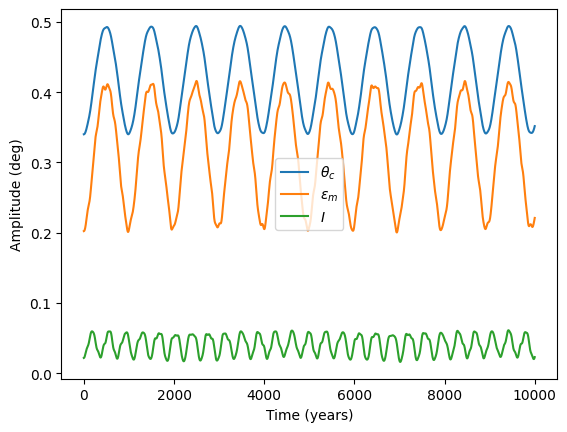

In [89]:
i=6
plt.plot(timeline,theta_f_time[i],label=r'$\theta_{c}$')
plt.plot(timeline,ep_m_time[i],label=r'$\epsilon_{m}$')
plt.plot(timeline,I_time[i]*(180/pi),label=r'$I$')
plt.xlabel('Time (years)')
plt.ylabel('Amplitude (deg)')
plt.legend()
#plt.savefig("preamp_h.pdf", format="pdf", bbox_inches="tight")
plt.show()  

# Viscous Dissipation

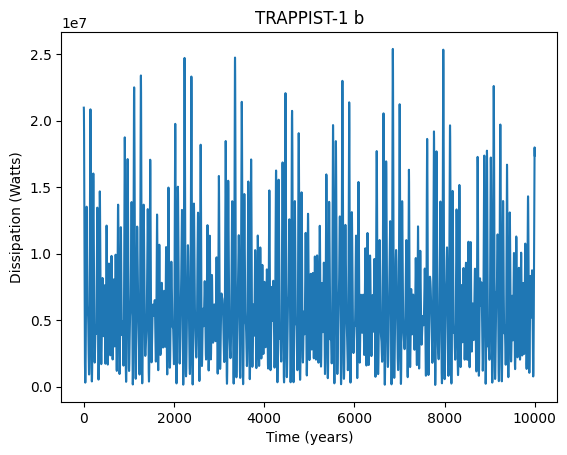

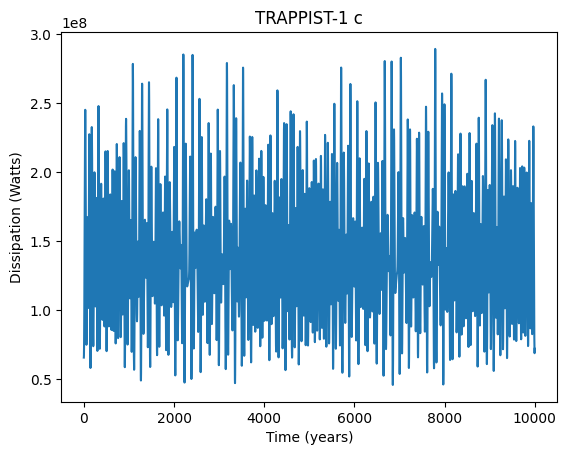

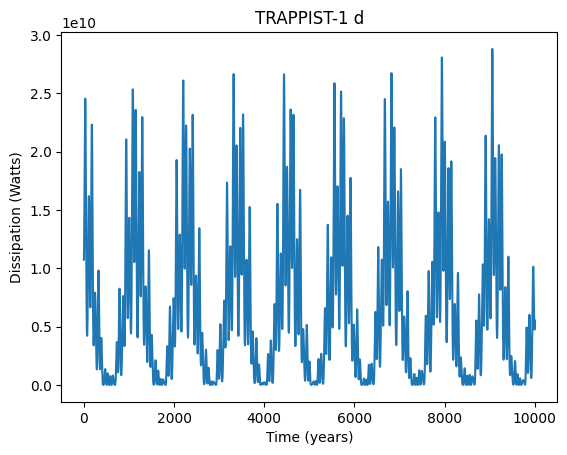

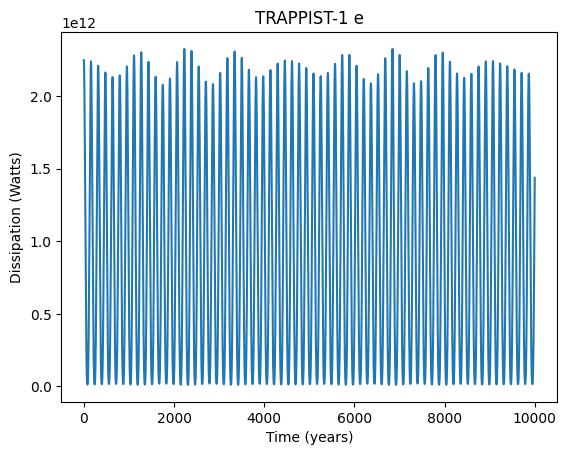

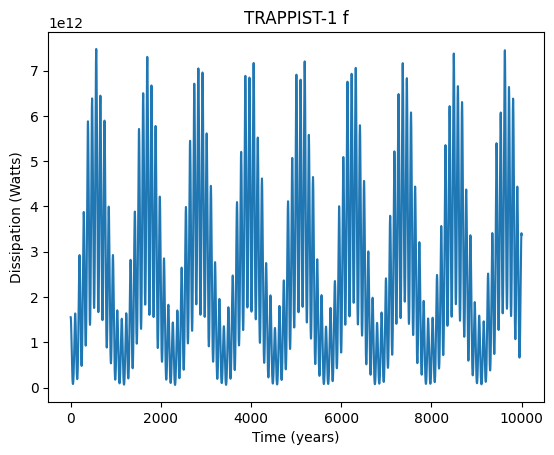

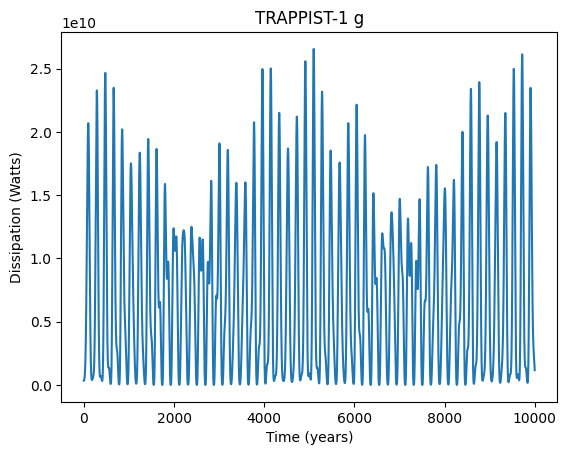

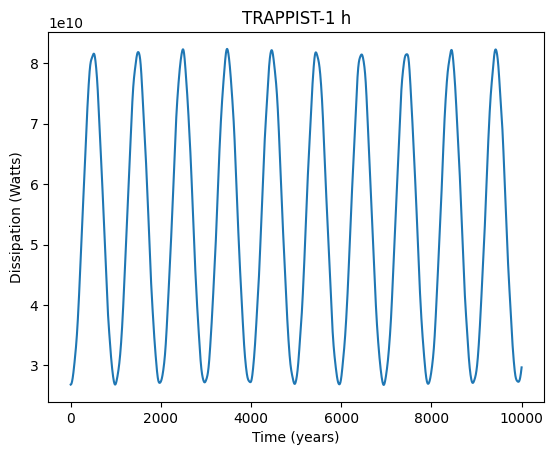

In [90]:
K_cmb = 4*10**-4
rot_rate = np.reshape(rot, (7, -1)) #rad/sec
rot_rate = rot_rate
If_cmb = np.reshape(If,(7,-1)) * 10**33 # kg m^2
Q_cmb  = K_cmb * ((3.0*pi**2)/4)*If_cmb*(rot_rate**3)*np.abs(np.sin(theta_f_time*(pi/180)))**3



for i in range(len(I_time)):
    plt.plot(timeline,Q_cmb[i],label=r'$\theta_{c}$')
    plt.xlabel('Time (years)')
    plt.ylabel('Dissipation (Watts)')
    plt.title(Table1['Planet Name'][i])
    #plt.legend()
    #plt.savefig(f"../New results/inclination,mantle_obl,core_offset/{Table1['Planet Name'][i]}.png")
    plt.show()

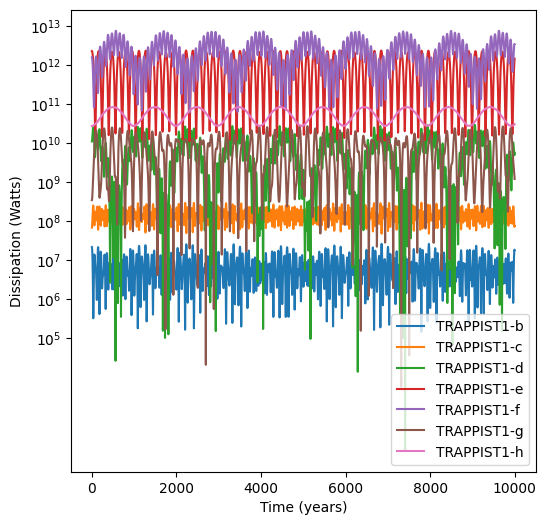

In [91]:
# Figure of dissipation for paper

plt.figure(figsize=(6,6))
plt.semilogy(timeline,Q_cmb[0],label=r'TRAPPIST1-b')
plt.semilogy(timeline,Q_cmb[1],label=r'TRAPPIST1-c')
plt.semilogy(timeline,Q_cmb[2],label=r'TRAPPIST1-d')
plt.semilogy(timeline,Q_cmb[3],label=r'TRAPPIST1-e')
plt.semilogy(timeline,Q_cmb[4],label=r'TRAPPIST1-f')
plt.semilogy(timeline,Q_cmb[5],label=r'TRAPPIST1-g')
plt.semilogy(timeline,Q_cmb[6],label=r'TRAPPIST1-h')
plt.xlabel('Time (years)')
plt.ylabel('Dissipation (Watts)')
plt.yticks([10**5,10**6,10**7,10**8,10**9,10**10,10**11,10**12,10**13])
#plt.yscale("log")
#plt.savefig("pre_dissip.pdf", format="pdf", bbox_inches="tight")
plt.legend()
plt.show()

# Mean Viscous dissipation 

In [92]:

iterations = 10**5
timeline10 = np.linspace(0,10000,iterations)

p_f_time10 = np.zeros([number_of_planets,iterations])
q_f_time10 = np.zeros([number_of_planets,iterations])

p_m_time10 = np.zeros([number_of_planets,iterations])
q_m_time10 = np.zeros([number_of_planets,iterations])

p_time10 = np.zeros([number_of_planets,iterations])
q_time10 = np.zeros([number_of_planets,iterations])

for i in range(iterations):
    p_time10[:,i] = np.matmul(eigvecs_B,T*np.sin(eigvals_B*timeline10[i]*(pi/180) ))
    q_time10[:,i] = np.matmul(eigvecs_B,T*np.cos(eigvals_B*timeline10[i]*(pi/180) ))

for i in range(iterations):
    p_f_time10[:,i] = np.matmul(theta_f0,np.sin(eigvals_B*timeline10[i]*(pi/180) ))
    q_f_time10[:,i] = np.matmul(theta_f0,np.cos(eigvals_B*timeline10[i]*(pi/180) ))

for i in range(iterations):
    p_m_time10[:,i] = np.matmul(ep_m0,np.sin(eigvals_B*timeline10[i]*(pi/180) ))
    q_m_time10[:,i] = np.matmul(ep_m0,np.cos(eigvals_B*timeline10[i]*(pi/180) ))

theta_f_time10 = np.sqrt(p_f_time10**2 + q_f_time10**2) #deg
ep_m_time10 = np.sqrt(p_m_time10**2 + q_m_time10**2) #deg
I_time10 = np.sqrt(p_time10**2 + q_time10**2) #rad


theta_f_time10 = np.array(theta_f_time10)

#print(theta_f_time10)
pre_diss  = K_cmb * ((3.0*pi**2)/4)*If_cmb*(rot_rate**3)*np.abs(np.sin(theta_f_time10*(pi/180)))**3


#print(pre_diss)

Rf = Rf.reshape((7,1))
rhof = rhof.reshape((7,1))
print(Rf)
print(rhof)
print(rot_rate)
v = 10**-6
print(np.sqrt(v/rot_rate))
pre_diss_lam =8*pi/15*(2.62)*((Rf*10**6)**4)*(rhof*1000)*np.sqrt(v/rot_rate)*(rot_rate**3)

print(pre_diss_lam)

pre_diss_lam =pre_diss_lam*(np.abs(np.sin(theta_f_time10*(pi/180))))**2


mean_pre_diss = []
for i in range(7):
    mean_pre_diss.append(np.mean(pre_diss[i]))
    
mean_pre_diss_lam = []
for i in range(7):
    mean_pre_diss_lam.append(np.mean(pre_diss_lam[i]))
    
mean_pre_diss = np.array(mean_pre_diss)
mean_pre_diss_lam = np.array(mean_pre_diss_lam)
#print(mean_lib_diss)

mean_thetaf =[]
for i in range(7):
    mean_thetaf.append(np.mean(theta_f_time10[i]))

mean_thetaf = np.array(mean_thetaf)

mean_thetaf = mean_thetaf.reshape((7,1))

Repre=(10**6)*Rf*np.sin(mean_thetaf*(pi/180))/delta_vskin

print(mean_thetaf)
print(mean_pre_diss)
print(mean_pre_diss_lam)
print(Repre)


[[3.2492403 ]
 [3.19600622]
 [2.26441704]
 [2.58446061]
 [2.95958221]
 [3.2063344 ]
 [2.13640424]]
[[12.]
 [12.]
 [10.]
 [12.]
 [12.]
 [12.]
 [10.]]
[[4.81339692e-05]
 [3.00264013e-05]
 [1.79595256e-05]
 [1.19196684e-05]
 [7.89809788e-06]
 [5.88725927e-06]
 [3.87378529e-06]]
[[0.14413656]
 [0.1824939 ]
 [0.23596771]
 [0.28964625]
 [0.35582687]
 [0.41213872]
 [0.50808015]]
[[9.43816683e+16]
 [2.71531244e+16]
 [1.57765739e+15]
 [1.15284587e+15]
 [7.08531317e+14]
 [4.68219287e+14]
 [2.70098690e+13]]
[[0.00075773]
 [0.00362938]
 [0.03496722]
 [0.21881489]
 [0.37686376]
 [0.06048486]
 [0.41994516]]
[6.73327914e+06 1.42300640e+08 6.41069349e+09 9.57244951e+11
 2.39793982e+12 7.34793884e+09 5.30203872e+10]
[1.76722655e+07 1.10472963e+08 7.17048899e+08 1.96329536e+10
 3.33981163e+10 6.14949079e+08 1.47482933e+09]
[[  298.1268807 ]
 [ 1109.35034358]
 [ 5856.55649102]
 [34076.51659341]
 [54707.92982427]
 [ 8212.76501295]
 [30818.90936126]]


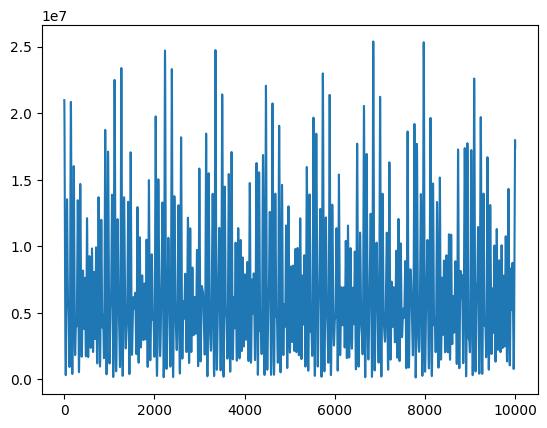

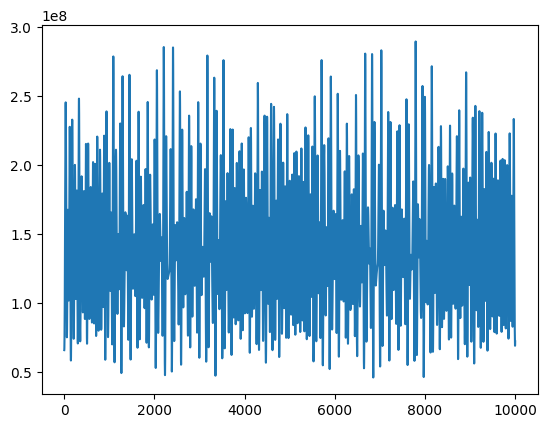

In [93]:
plt.plot(timeline10,pre_diss[0])
plt.show()
plt.plot(timeline10,pre_diss[1])
plt.show()



In [95]:

data = {
    'Name': ['TRAPPIST-1 b','TRAPPIST-1 c','TRAPPIST-1 d',
                    'TRAPPIST-1 e','TRAPPIST-1 f','TRAPPIST-1 g'
                    ,'TRAPPIST-1 h']
}

Table7 = pd.DataFrame(data=data)
Table7[r'$\theta_f$ (deg)'] = mean_thetaf
Table7[r'$Re_{p}$'] = Repre
Table7[r'${\cal D}_{p}^{lam}$ (W)'] = mean_pre_diss_lam
Table7[r'${\cal D}_{p}^{tur}$ (W)'] = mean_pre_diss
Table7.style.hide(axis='index')
Table7

Name  $\theta_f$ (deg)  $Re_{p}$  ${\cal D}_{p}^{lam}$ (W)   
0  TRAPPIST-1 b         7.577e-04 2.981e+02                 1.767e+07  \
1  TRAPPIST-1 c         3.629e-03 1.109e+03                 1.105e+08   
2  TRAPPIST-1 d         3.497e-02 5.857e+03                 7.170e+08   
3  TRAPPIST-1 e         2.188e-01 3.408e+04                 1.963e+10   
4  TRAPPIST-1 f         3.769e-01 5.471e+04                 3.340e+10   
5  TRAPPIST-1 g         6.048e-02 8.213e+03                 6.149e+08   
6  TRAPPIST-1 h         4.199e-01 3.082e+04                 1.475e+09   

   ${\cal D}_{p}^{tur}$ (W)  
0                 6.733e+06  
1                 1.423e+08  
2                 6.411e+09  
3                 9.572e+11  
4                 2.398e+12  
5                 7.348e+09  
6                 5.302e+10

# Growth and decay rate of Conical Shear Instability

In [96]:
Ek =v/rot_rate/((Rf*10**6)**2) 
sqEk = np.sqrt(Ek)

growthlib = mean_lib_amp*Ek**(0.2)
growthpre = np.pi/180.0*mean_thetaf*Ek**(0.2)

data = {
    'Name': ['TRAPPIST-1 b','TRAPPIST-1 c','TRAPPIST-1 d',
                    'TRAPPIST-1 e','TRAPPIST-1 f','TRAPPIST-1 g'
                    ,'TRAPPIST-1 h']
}
pd.options.display.float_format = '{:.3e}'.format
Table8 = pd.DataFrame(data=data)
Table8[r'$\theta_f$ (deg)'] = mean_thetaf
Table8[r'$\gamma_o$ (rad)'] = mean_lib_amp
Table8[r'$E_k$'] = Ek
Table8[r'$\sqrt{E_k}$'] = sqEk
Table8[r'$\theta_f E_k^{1/5}$'] = growthpre
Table8[r'$\gamma_o E_k^{1/5}$'] = growthlib
Table8.style.hide(axis='index')
Table8

Name  $\theta_f$ (deg)  $\gamma_o$ (rad)     $E_k$  $\sqrt{E_k}$   
0  TRAPPIST-1 b         7.577e-04         8.996e-05 1.968e-15     4.436e-08  \
1  TRAPPIST-1 c         3.629e-03         2.661e-05 3.260e-15     5.710e-08   
2  TRAPPIST-1 d         3.497e-02         6.407e-05 1.086e-14     1.042e-07   
3  TRAPPIST-1 e         2.188e-01         1.115e-05 1.256e-14     1.121e-07   
4  TRAPPIST-1 f         3.769e-01         4.844e-06 1.445e-14     1.202e-07   
5  TRAPPIST-1 g         6.048e-02         1.578e-06 1.652e-14     1.285e-07   
6  TRAPPIST-1 h         4.199e-01         5.169e-07 5.656e-14     2.378e-07   

   $\theta_f E_k^{1/5}$  $\gamma_o E_k^{1/5}$  
0             1.514e-08             1.030e-07  
1             8.024e-08             3.371e-08  
2             9.833e-07             1.032e-07  
3             6.335e-06             1.849e-08  
4             1.122e-05             8.264e-09  
5             1.850e-06             2.765e-09  
6             1.643e-05             1.158e-09